# MVPA analysis: Preprocessing and quality control

`
Authors:
Egor Ananyev
Jit Wei Ang Aaron
`

`
Based on the code by:
Alexandre Gramfort
Denis A. Engemann
`

In [115]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import os

In [16]:
mne.set_log_level('warning')  # less verbose output

## Important parameters

In [212]:
cur_subj = 1
cur_run = 1

interactive = False  # Whether to render interactive figures such as channel plots
debug = False

## Access raw data

In [18]:
data_path = os.path.expanduser("C:\\Users\\egora\\Downloads\\meg\\")

cur_subj_str = str(cur_subj).zfill(2)
cur_run_str = str(cur_run).zfill(2)

raw_fname = os.path.join(data_path,
                         'derivatives\\meg_derivatives\\' + 'sub-' + cur_subj_str + '\\ses-meg\\meg\\' + 'sub-' + \
                         cur_subj_str + '_ses-meg_experimental_run-' + cur_run_str + '_proc-sss_raw.fif')

In [19]:
print(raw_fname)

C:\Users\egora\Downloads\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-01_proc-sss_raw.fif


In [20]:
ls $raw_fname

 Volume in drive C is Acer
 Volume Serial Number is FAD5-0445

 Directory of C:\Users\egora\Downloads\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg

2020-02-05  15:59       362,181,396 sub-01_ses-meg_experimental_run-01_proc-sss_raw.fif
               1 File(s)    362,181,396 bytes
               0 Dir(s)  81,886,552,064 bytes free


Read data from file:

In [21]:
raw = mne.io.read_raw_fif(raw_fname, preload=False)
print(raw)

<Raw  |  sub-01_ses-meg_experimental_run-01_proc-sss_raw.fif, n_channels x n_times : 327 x 290000 (290.0 sec), ~5.5 MB, data not loaded>


In [22]:
print(raw.info)

1580887334
<Info | 28 non-empty fields
    acq_pars : str | 25272 items
    bads : list | 0 items
    ch_names : list | EOG001, EOG002, ECG003, MEG0111, MEG0112, MEG0113, ...
    chs : list | 327 items (EOG: 2, ECG: 1, MAG: 102, GRAD: 204, MISC: 1, STIM: 7, SYST: 1, CHPI: 9)
    comps : list | 0 items
    custom_ref_applied : bool | False
    description : str | 34 items
    dev_head_t : Transform | 3 items
    dig : Digitization | 149 items (3 Cardinal, 4 HPI, 142 Extra)
    events : list | 1 items
    experimenter : str | 17 items
    file_id : dict | 4 items
    gantry_angle : float | 68.0
    highpass : float | 0.10000000149011612 Hz
    hpi_meas : list | 1 items
    hpi_results : list | 1 items
    hpi_subsystem : dict | 2 items
    line_freq : float | 50.0
    lowpass : float | 330.0 Hz
    meas_date : tuple | 1970-01-01 00:00:00 GMT
    meas_id : dict | 4 items
    nchan : int | 327
    proc_history : list | 1 items
    proj_id : ndarray | 1 items
    proj_name : str | 24 items


In [23]:
raw.info['sfreq']  # Sampling frequency

1000.0

In [24]:
raw.info['line_freq']

50.0

The powerline frequency. 50 Hz in Sg; 60 Hz in Taiwan.

Text(0.5, 0.98, 'Sensor Positions')

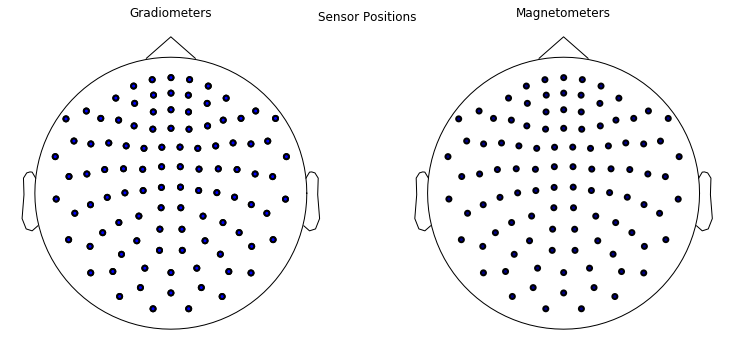

In [25]:
%matplotlib inline
fig, (left, right) = plt.subplots(ncols=2, figsize=(10, 5))
raw.plot_sensors(kind='topomap', ch_type='grad', axes=left, show=False);
left.set_title('Gradiometers')
raw.plot_sensors(kind='topomap', ch_type='mag', axes=right, show=False);
right.set_title('Magnetometers')
fig.suptitle('Sensor Positions')

### 

In [35]:
if interactive:
    %matplotlib qt
    raw.plot()

## Timing correction

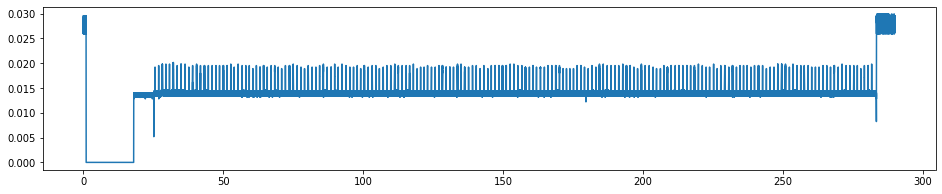

In [100]:
%matplotlib inline
light_sensor = raw.get_data(picks='MISC001')
plt.figure(figsize=(16, 3))
plt.plot(raw.times, light_sensor.T)

In [97]:
print('min ~ ' + '{0:.3f}'.format(np.min(light_sensor)))
print('max ~ ' + '{0:.3f}'.format(np.max(light_sensor)))

min ~ 0.000
max ~ 0.030


Based on the above, a light threshold of ~ 0.016 sounds reasonable:

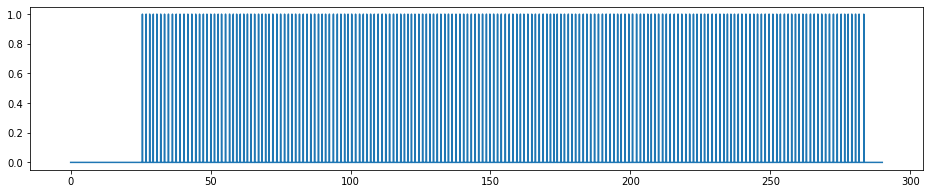

In [101]:
light_thresh = 0.016
too_bright = 0.025
light_sensor_thresholded = light_sensor
light_sensor_thresholded[light_sensor > too_bright] = 0  # this deals with the initial and final non-experimental period
light_sensor_thresholded[light_sensor < light_thresh] = 0
light_sensor_thresholded[light_sensor >= light_thresh] = 1
plt.figure(figsize=(16, 3))
plt.plot(raw.times, light_sensor_thresholded.T)

### Example data before correction

In [102]:
# Taking an excerpt from the data from 245 to 250 s:
start, stop = int(245 * raw.info['sfreq']), int(250 * raw.info['sfreq'])
data_excerpt, times = raw[:, start:stop]  # fetch all channels and the first 10 time points
print(data_excerpt.shape)  # should be 5000 samples at sfreq = 1000 Hz
print(times.shape)

(327, 5000)
(5000,)


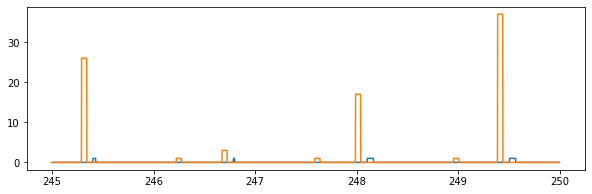

In [111]:
plt.figure(figsize=(10,3))
plt.plot(raw.times[start:stop], light_sensor_thresholded.T[start:stop])
trigger_channel_excerpt = raw.get_data(picks='STI101', start=start, stop=stop) - 2048
plt.plot(raw.times[start:stop], trigger_channel_excerpt.T)

### Preparing the timing correction

Instead of applying timing correction per se, I modify the light sensor channel (MISC001) to carry trigger information and use this instead of STI101.

In [218]:
trigger_channel = raw.get_data(picks='STI101') - 2048
trigger_channel[trigger_channel == 1] = 0
start = 0
stop = len(trigger_channel[0])
print('Taking samples ' + str(start) + ' to ' + str(stop))

Taking samples 0 to 290000


In [219]:
# number of trials is the number of triggers == 1, but for now, I'll hardcode:
numof_trials = 192

### Logic of light-sensor indexing

This is just a demonstration of how the light sensor timestamps are identified.

In [220]:
new_start = np.min(np.where(light_sensor_thresholded[0, :] == 1))
print('the first instance of light sensor above threshold: ' + str(new_start))

the first instance of light sensor above threshold: 25627


In [221]:
print('thresh light value prior to blip start = ' + str(light_sensor_thresholded[0, new_start-1]))
print('thresh light value at blip start = ' + str(light_sensor_thresholded[0, new_start]))

thresh light value prior to blip start = 0.0
thresh light value at blip start = 1.0


In [222]:
blip_dur = np.min(np.where(light_sensor_thresholded[0, new_start:stop] == 0))
print(blip_dur)  # duration of the light sensory == 1 blip

12


In [223]:
print('thresh light value prior to blip end = ' + str(light_sensor_thresholded[0, new_start+blip_dur-1]))
print('thresh light value at blip start = ' + str(light_sensor_thresholded[0, new_start+blip_dur]))

thresh light value prior to blip end = 1.0
thresh light value at blip start = 0.0


### Identifying light sensor timestamps & quantifying the mismatch

In [224]:
trigger_samples = pd.DataFrame(data = {'STI_sample': np.repeat(0, numof_trials),
                                       'LS_sample': np.repeat(0, numof_trials),
                                       'LS_dur': np.repeat(0, numof_trials),
                                       'sample_mismatch': np.repeat(0, numof_trials)})
# print(trigger_samples)

In [225]:
start = 0
for cur_trial in range(numof_trials):
    stim_sample = start + np.min(np.where(trigger_channel[0, start:stop] > 0))
    trigger_samples.at[cur_trial, 'STI_sample'] = stim_sample
    light_sample = start + np.min(np.where(light_sensor_thresholded[0, start:stop] == 1))
    trigger_samples.at[cur_trial, 'LS_sample'] = light_sample
    blip_dur = np.min(np.where(light_sensor_thresholded[0, light_sample:stop] == 0))
    trigger_samples.at[cur_trial, 'LS_dur'] = blip_dur
    trigger_samples.at[cur_trial, 'sample_mismatch'] = light_sample - stim_sample
    start = light_sample + blip_dur + 1
    if debug:
        print('=============================================')
        print('stim_sample = ' + str(stim_sample))
        print('light_sample = ' + str(light_sample))
        print('blip_dur = ' + str(blip_dur))
        print('mismatch = ' + str(light_sample - stim_sample))
        print(start)

In [226]:
print(trigger_samples)  # STI = stimulus channel; LS = light sensor channel

     STI_sample  LS_sample  LS_dur  sample_mismatch
0         25522      25627      12              105
1         26806      26912      45              106
2         28089      28197      62              108
3         29389      29499      29              110
4         30656      30767      46              111
..          ...        ...     ...              ...
187      276427     276542      28              115
188      277676     277793      12              117
189      278944     279062      45              118
190      280277     280397      62              120
191      281562     281665      46              103

[192 rows x 4 columns]


In [227]:
trigger_samples['sample_mismatch'].describe()

count    192.000000
mean     111.817708
std        5.108570
min      101.000000
25%      107.000000
50%      112.000000
75%      116.000000
max      121.000000
Name: sample_mismatch, dtype: float64

The range (in samples) of temporal mismatch between the light sensor and the triggers:

In [228]:
print(np.max(trigger_samples['sample_mismatch']) - 
      np.min(trigger_samples['sample_mismatch']))

20
